<a href="https://colab.research.google.com/github/amansandhu408/deep-learning/blob/main/mobilenetv2_5folds_97_78.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [ ]:
IMG_SIZE = 224
NUM_CLASSES = 3
VALID_EXT = (".png", ".jpg", ".jpeg")

BASE = "/kaggle/input/datasets/amansandhu408/spectrograms/spectrograms"
path_24 = os.path.join(BASE, "24GHz")
path_77 = os.path.join(BASE, "77GHz")
path_xe = os.path.join(BASE, "Xethru")


In [ ]:
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False
def load_three_radar_data(p1, p2, p3, classes):

    X1, X2, X3, Y = [], [], [], []

    for label, cls in enumerate(classes):

        d1 = os.path.join(p1, cls)
        d2 = os.path.join(p2, cls)
        d3 = os.path.join(p3, cls)

        f1 = sorted([f for f in os.listdir(d1) if f.lower().endswith(VALID_EXT)])
        f2 = sorted([f for f in os.listdir(d2) if f.lower().endswith(VALID_EXT)])
        f3 = sorted([f for f in os.listdir(d3) if f.lower().endswith(VALID_EXT)])

        min_len = min(len(f1), len(f2), len(f3))

        for i in range(min_len):

            p_1 = os.path.join(d1, f1[i])
            p_2 = os.path.join(d2, f2[i])
            p_3 = os.path.join(d3, f3[i])

            if not (is_valid_image(p_1) and is_valid_image(p_2) and is_valid_image(p_3)):
                continue

            img1 = np.array(Image.open(p_1).resize((IMG_SIZE, IMG_SIZE))) / 255.0
            img2 = np.array(Image.open(p_2).resize((IMG_SIZE, IMG_SIZE))) / 255.0
            img3 = np.array(Image.open(p_3).resize((IMG_SIZE, IMG_SIZE))) / 255.0

            X1.append(img1)
            X2.append(img2)
            X3.append(img3)
            Y.append(label)

    return np.array(X1), np.array(X2), np.array(X3), np.array(Y)


In [ ]:
classes = sorted(os.listdir(path_24))

X24, X77, Xxe, y_original = load_three_radar_data(
    path_24, path_77, path_xe, classes
)


In [ ]:
class_map = {
    'sitting': 0,
    'kneeling': 0,
    'bending': 0,
    'picking_up_object': 0,

    'limping': 1,
    'scissors_gait': 1,
    'short_steps': 1,

    'crawling': 2,
    'walking_towards_radar': 2,
    'walking_away_from_radar': 2,
    'walking_on_both_toes': 2
}

y_3class = np.array([class_map[classes[label]] for label in y_original])


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

I0000 00:00:1771235851.623376      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771235851.629185      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
def build_encoder():
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )

    base.trainable = True
    for layer in base.layers[:-30]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    return models.Model(base.input, x)

In [ ]:
def attention_fusion(f24, f77, fxe):

    a24 = layers.Dense(1)(f24)
    a77 = layers.Dense(1)(f77)
    axe = layers.Dense(1)(fxe)

    concat = layers.Concatenate()([a24, a77, axe])
    weights = layers.Softmax()(concat)

    w24 = layers.Lambda(lambda x: x[:,0:1])(weights)
    w77 = layers.Lambda(lambda x: x[:,1:2])(weights)
    wxe = layers.Lambda(lambda x: x[:,2:3])(weights)

    f24 = layers.Multiply()([f24, w24])
    f77 = layers.Multiply()([f77, w77])
    fxe = layers.Multiply()([fxe, wxe])

    return layers.Add()([f24, f77, fxe])


In [ ]:
def build_model():

    enc24 = build_encoder()
    enc77 = build_encoder()
    encxe = build_encoder()

    in24 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    in77 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    inxe = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    aug24 = data_augmentation(in24)
    aug77 = data_augmentation(in77)
    augxe = data_augmentation(inxe)

    f24 = enc24(layers.GaussianNoise(0.02)(aug24))
    f77 = enc77(layers.GaussianNoise(0.02)(aug77))
    fxe = encxe(layers.GaussianNoise(0.02)(augxe))

    fused = attention_fusion(f24, f77, fxe)

    x = layers.Dense(512, activation="relu")(fused)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model([in24, in77, inxe], out)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=1e-4
    )

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )

    return model


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_no = 1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


========== Fold 1 ==========
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40


I0000 00:00:1771235890.711448     124 cuda_dnn.cc:529] Loaded cuDNN version 91002


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 361ms/step - accuracy: 0.3475 - loss: 1.5931 - val_accuracy: 0.3651 - val_loss: 1.1078
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5535 - loss: 1.0020 - val_accuracy: 0.3889 - val_loss: 1.0689
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.6150 - loss: 0.8297 - val_accuracy: 0.3810 - val_loss: 1.0552
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7413 - loss: 0.6305 - val_accuracy: 0.3810 - val_loss: 1.0240
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.7966 - loss: 0.5632 - val_accuracy: 0.4921 - val_loss: 0.9360
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.8223 - loss: 0.5073 - val_accuracy: 0.4921 - val_loss: 0.9439
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.8523 - loss: 0.5119 - val_accuracy: 0.5317 - val_loss: 0.9034
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9127 - loss: 0.3962 - val_accuracy: 0.5952 - val

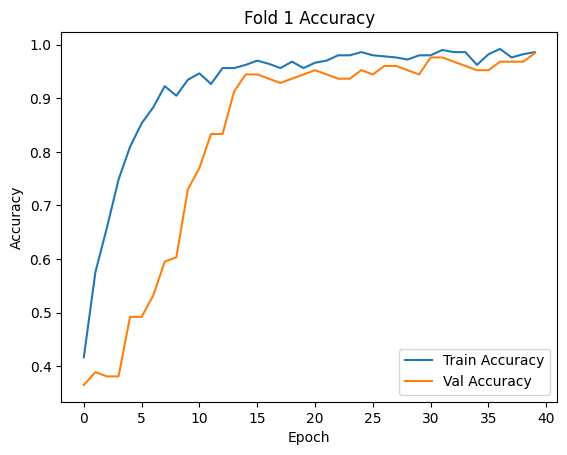

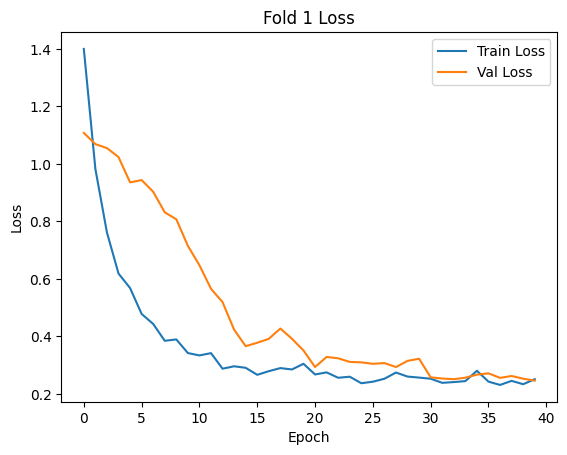


========== Fold 2 ==========
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 321ms/step - accuracy: 0.4241 - loss: 1.1594 - val_accuracy: 0.3333 - val_loss: 1.1082
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.7080 - loss: 0.7233 - val_accuracy: 0.3889 - val_loss: 1.0280
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8357 - loss: 0.5430 - val_accuracy: 0.5397 - val_loss: 0.9006
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9039 - loss: 0.3944 - val_accuracy: 0.5873 - val_loss: 0.8250
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8965 - loss: 0.4450 - val_accuracy: 0.6429 - val_loss: 0.7675
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9157 - loss: 0.3552 - val_accuracy: 0.7460 - val_loss: 0.6974
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9482 - loss: 0.3605 - val_accuracy: 0.8016 - val_loss: 0.6202
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9274 - 

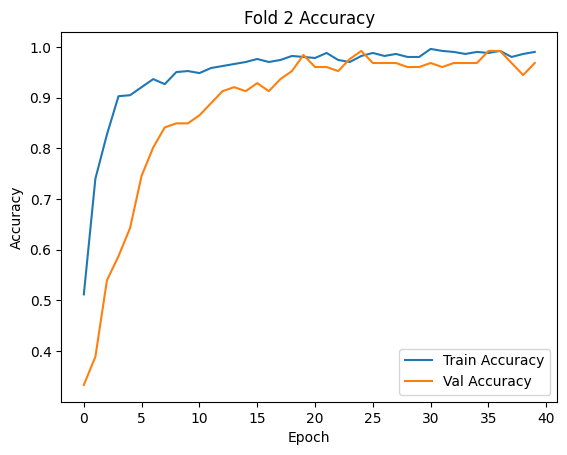

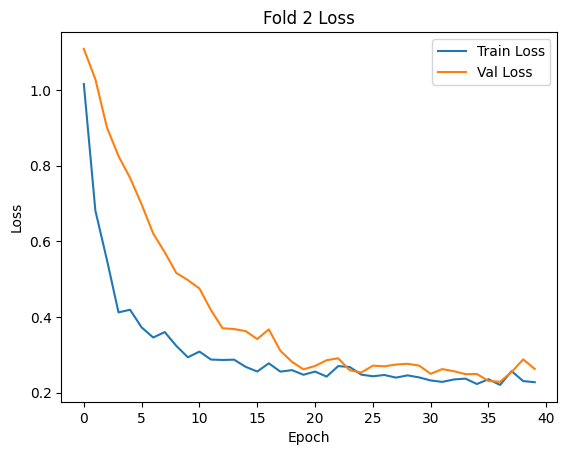


========== Fold 3 ==========
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 347ms/step - accuracy: 0.4323 - loss: 1.3284 - val_accuracy: 0.3810 - val_loss: 1.1209
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6535 - loss: 0.8923 - val_accuracy: 0.4762 - val_loss: 1.0598
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8283 - loss: 0.5489 - val_accuracy: 0.5714 - val_loss: 1.0009
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9083 - loss: 0.4272 - val_accuracy: 0.6190 - val_loss: 0.9553
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9042 - loss: 0.4198 - val_accuracy: 0.6587 - val_loss: 0.9127
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9284 - loss: 0.3516 - val_accuracy: 0.6667 - val_loss: 0.9235
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9372 - loss: 0.3372 - val_accuracy: 0.6508 - val_loss: 0.9556
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9263 - 

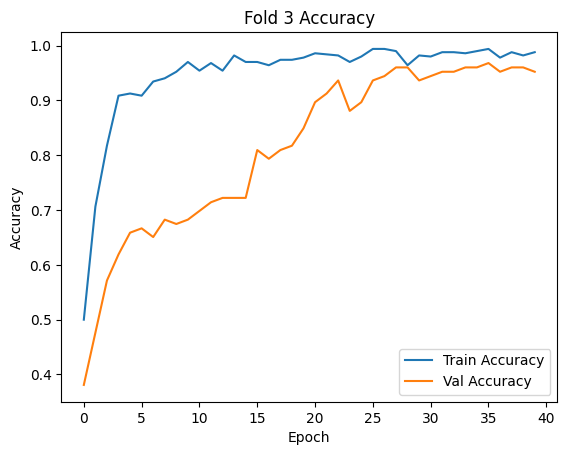

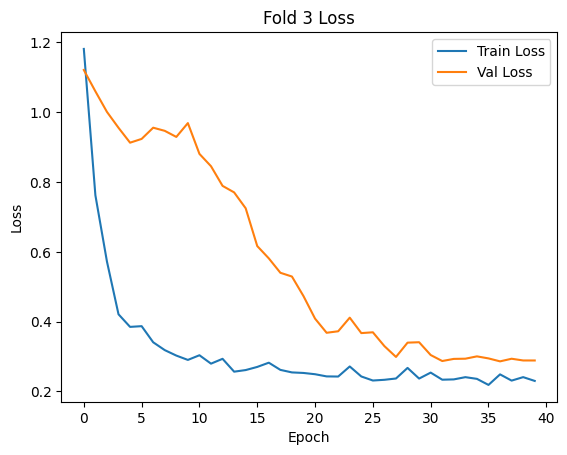


========== Fold 4 ==========
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step - accuracy: 0.3616 - loss: 1.4948 - val_accuracy: 0.4206 - val_loss: 1.0804
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.7143 - loss: 0.8002 - val_accuracy: 0.6190 - val_loss: 0.9850
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7816 - loss: 0.5702 - val_accuracy: 0.6349 - val_loss: 0.9294
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8825 - loss: 0.4319 - val_accuracy: 0.6984 - val_loss: 0.8551
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9037 - loss: 0.4026 - val_accuracy: 0.7381 - val_loss: 0.7871
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9098 - loss: 0.4005 - val_accuracy: 0.7381 - val_loss: 0.7365
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9195 - loss: 0.3638 - val_accuracy: 0.7937 - val_loss: 0.6630
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9349 - 

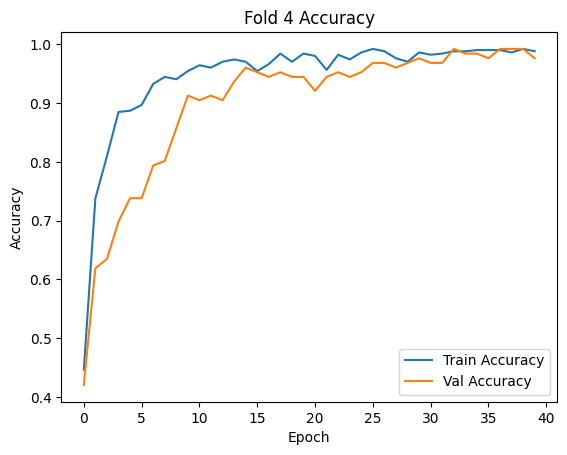

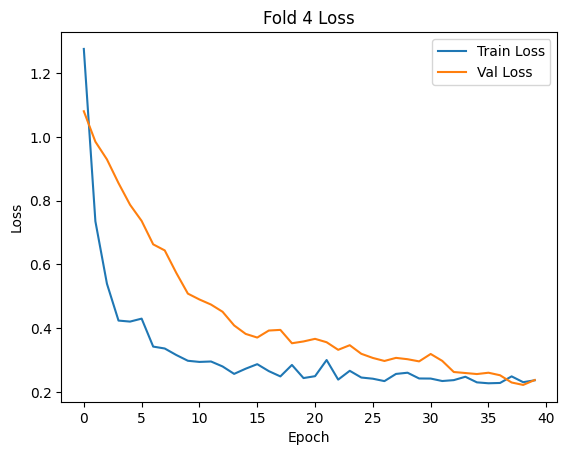


========== Fold 5 ==========
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 323ms/step - accuracy: 0.4274 - loss: 1.3719 - val_accuracy: 0.3333 - val_loss: 1.0383
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6684 - loss: 0.8209 - val_accuracy: 0.3571 - val_loss: 0.9957
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7924 - loss: 0.6145 - val_accuracy: 0.4762 - val_loss: 0.9699
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8196 - loss: 0.5038 - val_accuracy: 0.5317 - val_loss: 0.9155
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8783 - loss: 0.4629 - val_accuracy: 0.5714 - val_loss: 0.8676
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9267 - loss: 0.3875 - val_accuracy: 0.6111 - val_loss: 0.7869
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9064 - loss: 0.4075 - val_accuracy: 0.6667 - val_loss: 0.7642
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9189 - 

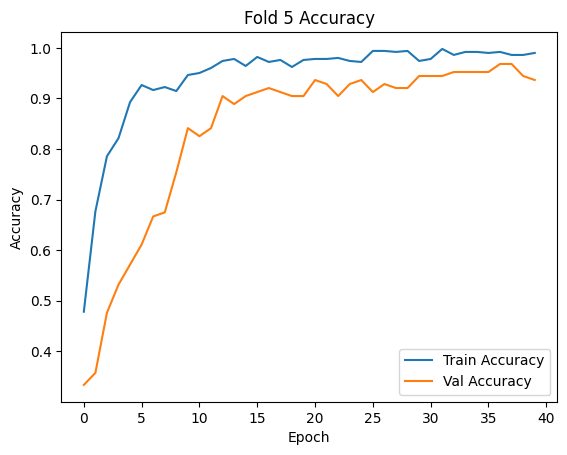

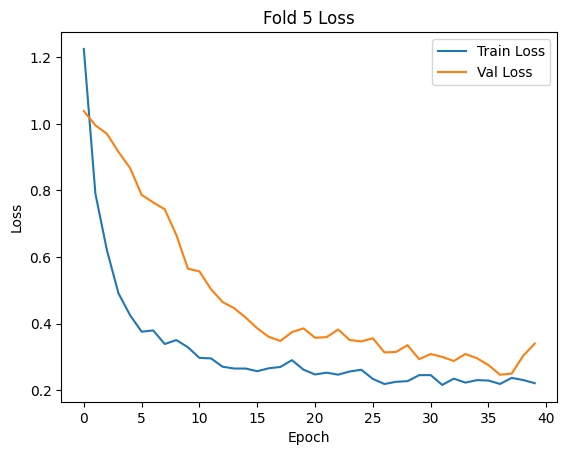

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_f1_scores = []

all_true = []
all_pred = []

fold_no = 1

for train_index, val_index in skf.split(X24, y_3class):

    print(f"\n========== Fold {fold_no} ==========")

    X24_train, X24_val = X24[train_index], X24[val_index]
    X77_train, X77_val = X77[train_index], X77[val_index]
    Xxe_train, Xxe_val = Xxe[train_index], Xxe[val_index]

    y_train, y_val = y_3class[train_index], y_3class[val_index]

    y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_val_cat   = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))

    model = build_model()

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    )

    #training
    start_time = time.time()

    history = model.fit(
        [X24_train, X77_train, Xxe_train],
        y_train_cat,
        validation_data=([X24_val, X77_val, Xxe_val], y_val_cat),
        epochs=40,
        batch_size=16,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=1
    )

    end_time = time.time()


    #inference time
    start_inf = time.time()
    preds = model.predict([X24_val, X77_val, Xxe_val])
    end_inf = time.time()

    # Evaluation
    val_loss, val_acc = model.evaluate(
        [X24_val, X77_val, Xxe_val],
        y_val_cat,
        verbose=0
    )

    fold_accuracies.append(val_acc)

    # Predictions
    y_pred = model.predict([X24_val, X77_val, Xxe_val])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true = y_val

    all_true.extend(y_true)
    all_pred.extend(y_pred_cls)

    # F1 Score
    f1 = f1_score(y_true, y_pred_cls, average='weighted')
    fold_f1_scores.append(f1)

    print(f"Fold {fold_no} Accuracy: {val_acc*100:.2f}%")
    print(f"Fold {fold_no} F1 Score: {f1:.4f}")
    print(f"Training Time: {end_time - start_time:.2f} sec")
    print(f"Inference Time: {end_inf - start_inf:.2f} sec")
    print("Per Sample:", (end_inf - start_inf)/len(X24_val), " sec")

    # 🔹 Accuracy vs Val Accuracy Plot
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {fold_no} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # 🔹 Loss vs Val Loss Plot
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold_no} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    fold_no += 1


In [ ]:
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)

mean_f1 = np.mean(fold_f1_scores)
std_f1  = np.std(fold_f1_scores)

print("\n==============================")
print(f"5-Fold Mean Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}")
print(f"5-Fold Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print("==============================")


5-Fold Mean Accuracy: 97.78% ± 1.54
5-Fold Mean F1 Score: 0.9777 ± 0.0155


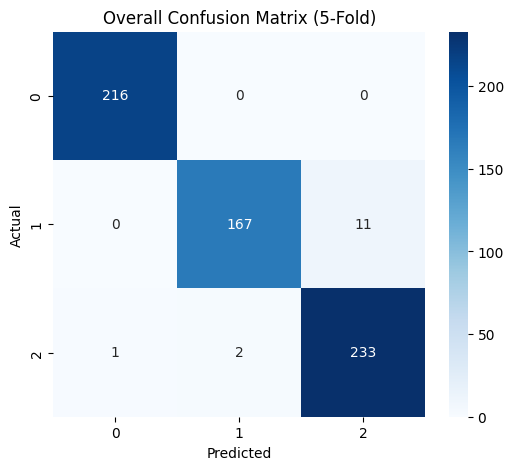


Classification Report (All Folds Combined):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       0.99      0.94      0.96       178
           2       0.95      0.99      0.97       236

    accuracy                           0.98       630
   macro avg       0.98      0.98      0.98       630
weighted avg       0.98      0.98      0.98       630



In [ ]:
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Overall Confusion Matrix (5-Fold)")
plt.show()

print("\nClassification Report (All Folds Combined):\n")
print(classification_report(all_true, all_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step
Feature shape: (126, 64)


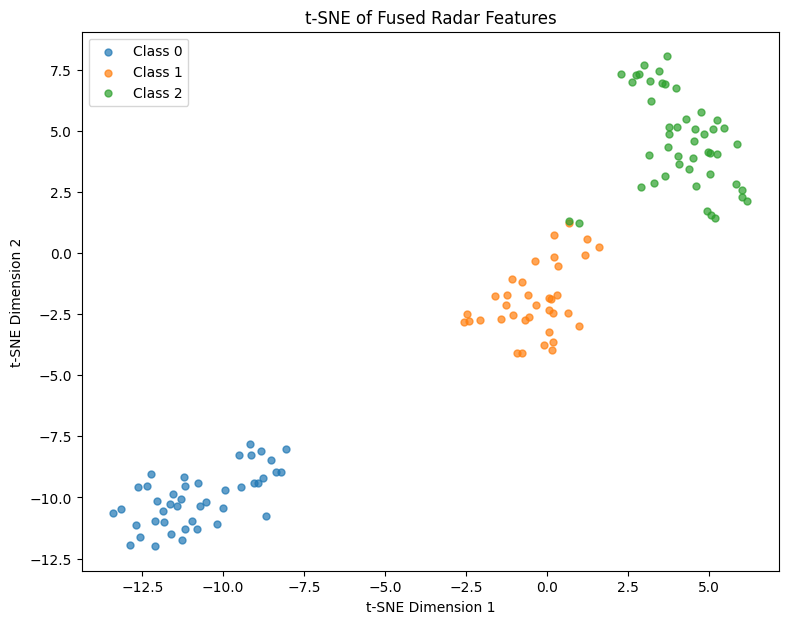

In [ ]:
# Extract features
feature_layer = model.layers[-2].output

feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=feature_layer
)

features = feature_extractor.predict(
    [X24_val, X77_val, Xxe_val],
    batch_size=16,
    verbose=1
)

print("Feature shape:", features.shape)

# True validation labels
y_true = np.argmax(y_val_cat, axis=1)

# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    init='pca'
)

features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(9, 7))

for class_id in range(NUM_CLASSES):
    idx = y_true == class_id
    plt.scatter(
        features_2d[idx, 0],
        features_2d[idx, 1],
        label=f"Class {class_id}",
        s=25,
        alpha=0.7
    )

plt.legend()
plt.title("t-SNE of Fused Radar Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
